# Import and definitions

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets#  HBox, VBox, IntSlider, Play, jslink, Layout, Label
import seaborn as sns
from IPython import display  # used for clearing plots, to view during the simulation
import time
import pickle
import gzip

import glob
import pandas as pd
import gc
import os
import scipy

snscolors=sns.color_palette()

# for calculating social interactions
import functions.PTWsimulation as ptw
# import functions.modelfunctions as mf

In [68]:
ind_x, ind_y, ind_vx, ind_vy, ind_spd, ind_ang, ind_angvel = np.arange(7)

In [69]:
savedir = '/mnt/storage/schisto_sims/pairsims/'

# Read in results and save in simple form

In [70]:
def getsavedsim(savename):
    model,allparticles,alldist,alldcoords_rotated = pickle.load(gzip.open(savedir+savename,'rb'))
    return model,allparticles,alldist,alldcoords_rotated


def getsimmetrics(savename,dskip=10,social_dsel=True):  # dskip just applies to saving vals
    model,allparticles,alldist,alldcoords_rotated = getsavedsim(savename)
    
    # only use instances when they are within the social zone, for calculating metrics
    focus=0
    sel = np.delete(np.arange(2),focus)
    d = alldist[:,focus,sel]
    if social_dsel:
        dsel = (d < model.r_attract)
    else :
        dsel = np.tile(True,d.shape)
    fns = [np.nanmean,np.nanstd,np.nanmedian]

    # calculate front-back distance and left-right distance
    c = alldcoords_rotated[:,focus,sel,0]
    tp = -c[dsel]
    fb = [fn(tp) for fn in fns]
    fb_val = tp[::dskip]

    c = alldcoords_rotated[:,focus,sel,1]
    tp = -c[dsel]                    
    lr = [fn(tp) for fn in fns]
    lr_val = tp[::dskip]           

    # calculate dtheta
    dtheta_full = np.ndarray.flatten(np.diff(allparticles[:,:,ind_ang])[dsel])
    dth = [fn(np.abs(dtheta_full)) for fn in fns]
    dth_val = dtheta_full[::dskip]

    # distance apart
    dist_full = np.ndarray.flatten(alldist[:,focus,sel][dsel])
    dist = [fn(dist_full) for fn in fns]
    dist_val = dist_full[::dskip]
    
    tp = allparticles[:,:,ind_spd]
    spd = np.array([[fn(tp[:,i]) for fn in fns] for i in range(2)])  # 2xlen(fn) array, of stats for speed
    spd_val = tp[::dskip]
    tp = allparticles[:,:,ind_angvel]
    angvel = np.array([[fn(tp[:,i]) for fn in fns] for i in range(2)])  # 2xlen(fn) array, of stats for angvel
    angvel_val = tp[::dskip]
    
    return fb, lr, dth, dist, fb_val, lr_val, dth_val, dist_val, spd, spd_val, angvel, angvel_val

def initarray(lengths):
    if len(lengths)==1:
        return [[] for _ in range(lengths[0])]
    else:
        return [initarray(lengths[1:]) for _ in range(lengths[0])]

## S13 A,C - vary social responsiveness ("social turning responsiveness")

In [72]:
simprefix = 'pairsameABC'

#(A) 
speedvalues = [ [0.8, 0.8], [1, 1], [1.2, 1.2], [1.1, 0.9], [1.2, 0.8] ]
#(B)
socialweights = [0, 0.25, 0.5, 0.75, 1]
socialweights = np.arange(0,1.01,0.1)
#(C) 
sigma_turns = [2,3]
#(D) 
speedsocialweights = [0,0.1]

# stopgo:  on/off
#(m) 
stopgosocials = [0,0.4,0.8]
#(n) Tswitch:  Fish 1 always [10,10].  Fish 2:  [10,10], [30,10]  "Time in each state [go,stop]"  (2 cases)
Tswitchs = [[10,10], [30,10]]  # Tswitch values for Fish 2


# parameters that I'm not varying this time
tau_speed = 1
statespeedmult = np.array([[1. , 0.2],[1. , 0.2]])

# simulation configuration and other set parameters
numparticles=2

# numsteps=100
numsteps = 20 * 10**6  # should really use 2 * 10**6
dt = 0.1
# numsteps=100

# set outside the loop
m = 2 # stopgosocial  

# for m in range(3):
n = 0 # Tswitch

A = 1 #  speedvalues.  1-->[1,1]
# B = 2 # socialweight.  
# C = 2 # sigma_turn.  
D = 0 # speedsocialweight

process_raw_results = False
if process_raw_results:

    lengths = [2,len(sigma_turns),len(socialweights)]
    frontback = np.zeros(np.append(lengths,3))
    leftright = np.zeros(np.append(lengths,3))
    dtheta = np.zeros(np.append(lengths,3))
    distapart = np.zeros(np.append(lengths,3))
    speed = np.zeros(np.concatenate((lengths,[2,3])))
    angvel = np.zeros(np.concatenate((lengths,[2,3])))

    for snum in range(2):
        for C in range(len(sigma_turns)):
            for B in range(len(socialweights)):    
                if snum==1:  # then stopgosim=True
                    savename = simprefix+'_'+str(m)+str(n)+'_params_'+str(A)+str(B)+str(C)+str(D)+'.pklz'
                else:
                    savename = simprefix+'_params_'+str(A)+str(B)+str(C)+str(D)+'.pklz'        
                [model,allparticles,alldist,alldcoords_rotated] = pickle.load( gzip.open(savedir+savename,'rb') )
                fb, lr, dth, dist, fb_val, lr_val, dth_val, dist_val, s, s_val, av, av_val = getsimmetrics(savename,dskip=10,social_dsel=False)  # if social_dsel=False, then name it '-alld'            
                frontback[snum,C,B] = fb
                leftright[snum,C,B] = lr
                dtheta   [snum,C,B] = dth
                distapart[snum,C,B] = dist
                speed [snum,C,B] = s
                angvel[snum,C,B] = av

    outfile = 'simresults/'+simprefix+'.pkl'
    pickle.dump([frontback,leftright,dtheta,distapart,speed,angvel],open(outfile,'wb'))
    print('wrote to:',outfile)
else:
    outfile = 'simresults/'+simprefix+'.pkl'
    [frontback,leftright,dtheta,distapart,speed,angvel] = pickle.load(open(outfile,'rb'))

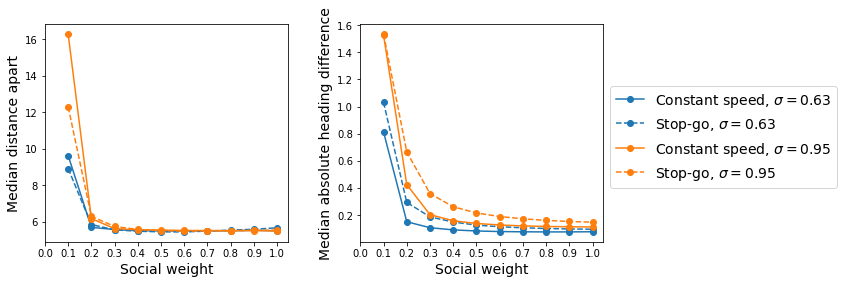

In [74]:
f,ax = plt.subplots(1,2,sharex=True)
f.set_size_inches(10,4)
statnum = 2  # 0=mean, 1=stddev, 2=median
for C in range(2):
    for snum in range(2):
        Clabel = ', ' + '$\sigma=$' + str(round(sigma_turns[C]*np.sqrt(0.1),2))
        label=['Constant speed','Stop-go'][snum] + Clabel
        style = '-o' if snum==0 else '--o'
        #  Distance apart
        a=ax[0]
        a.plot(socialweights[1:],distapart[snum,C,:][1:,statnum],style,label=label,c=snscolors[C])
        a.set_ylabel('Median distance apart',fontsize=14)

        # Alignment
        a=ax[1]
        a.plot(socialweights[1:],dtheta[snum,C,:][1:,statnum],style,label=label,c=snscolors[C])
        a.set_ylabel('Median absolute heading difference',fontsize=14)

for a in ax:
    a.set_xticks(socialweights)
    a.set_xlabel('Social weight',fontsize=14)

a.legend(bbox_to_anchor=(1, 0.75),fontsize=14)    
plt.subplots_adjust(wspace=0.3)
# ax[0].set_ylim([5.3,6.8])
# ax[1].set_ylim([0,0.5])

In [ ]:
D = 0 # speedsocialweight
plotdata = np.zeros((3,2,4))  # [iid vs heading dist vs ang vel, model=snum, socialweight case]
for snum in range(2):  # snum refers to 'stop-go num'
    plotdata[0,snum,:] = distapart[snum,m,n,A,1:,C,D][:,statnum]
    plotdata[1,snum,:] = dtheta[snum,m,n,A,1:,C,D][:,statnum]
    plotdata[2,snum,:] = angvel[snum,m,n,A,1:,C,D][:,0,1]

forpandas = []

for j in range(2): # model
    modelname = ['Constant speed','Stop-go'][j]
    for k in range(4):  # social value
        socialweight = socialweights[k+1]
        forpandas.append([modelname,socialweight,plotdata[0,j,k],plotdata[1,j,k],plotdata[2,j,k]])
columns = ['model','socialweight','IID','alignment','ang vel std dev']
df=pd.DataFrame(data=forpandas,columns=columns)
df.to_csv('simresults/pair-socialweight.csv')
df

## S 13 B, D:  Vary turning noise

In [75]:
simprefix = 'pairsameDEF'

#(A) 
speedvalues = [ [0.8, 0.8], [1, 1], [1.2, 1.2], [1.1, 0.9], [1.2, 0.8] ]
#(B)
socialweights = [0.2, 0.5]
#(C) 
sigma_turns = np.arange(0.5,5.01,0.5)
#(D) 
speedsocialweights = [0,0.1]

# stopgo:  on/off
#(m) 
stopgosocials = [0,0.4,0.8]
#(n) Tswitch:  Fish 1 always [10,10].  Fish 2:  [10,10], [30,10]  "Time in each state [go,stop]"  (2 cases)
Tswitchs = [[10,10], [30,10]]  # Tswitch values for Fish 2


# parameters that I'm not varying this time
tau_speed = 1
statespeedmult = np.array([[1. , 0.2],[1. , 0.2]])

# simulation configuration and other set parameters

# numsteps=100


# set outside the loop
m = 2 # stopgosocial  

# for m in range(3):
n = 0 # Tswitch

A = 1 #  speedvalues.  1-->[1,1]
B = 2 # socialweight.  
# C = 2 # sigma_turn.  
D = 0 # speedsocialweight

process_raw_results = False
if process_raw_results:
    lengths = [2,len(socialweights),len(sigma_turns)]
    frontback = np.zeros(np.append(lengths,3))
    leftright = np.zeros(np.append(lengths,3))
    dtheta = np.zeros(np.append(lengths,3))
    distapart = np.zeros(np.append(lengths,3))
    speed = np.zeros(np.concatenate((lengths,[2,3])))
    angvel = np.zeros(np.concatenate((lengths,[2,3])))

    for snum in range(2):
        for B in range(len(socialweights)):    
            print(B)
            for C in range(len(sigma_turns)):        
                if snum==1:  # then stopgosim=True
                    savename = simprefix+'_'+str(m)+str(n)+'_params_'+str(A)+str(B)+str(C)+str(D)+'.pklz'
                else:
                    savename = simprefix+'_params_'+str(A)+str(B)+str(C)+str(D)+'.pklz'        
                [model,allparticles,alldist,alldcoords_rotated] = pickle.load( gzip.open(savedir+savename,'rb') )
                fb, lr, dth, dist, fb_val, lr_val, dth_val, dist_val, s, s_val, av, av_val = getsimmetrics(savename,dskip=10,social_dsel=False)  # if social_dsel=False, then name it '-alld'            
                frontback[snum,B,C] = fb
                leftright[snum,B,C] = lr
                dtheta   [snum,B,C] = dth
                distapart[snum,B,C] = dist
                speed [snum,B,C] = s
                angvel[snum,B,C] = av
    outfile = 'simresults/'+simprefix+'.pkl'
    pickle.dump([frontback,leftright,dtheta,distapart,speed,angvel],open(outfile,'wb'))
    print('wrote to:',outfile)                
else:
    outfile = 'simresults/'+simprefix+'.pkl'
    [frontback,leftright,dtheta,distapart,speed,angvel] = pickle.load(open(outfile,'rb'))                

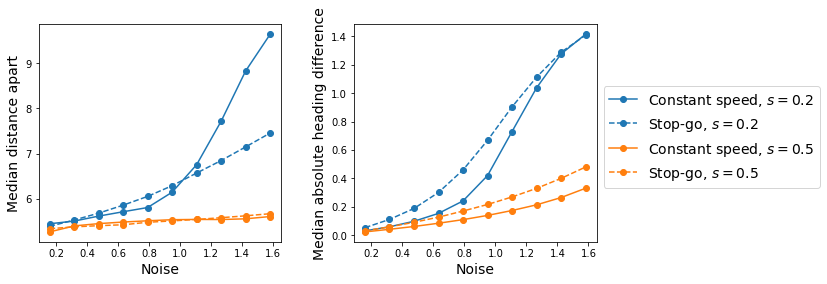

In [77]:
f,ax = plt.subplots(1,2,sharex=True)
f.set_size_inches(10,4)
statnum = 2  # 0=mean, 1=stddev, 2=median

for B in range(2):
    for snum in range(2):
        Clabel = ', ' + '$s=$' + str(round(socialweights[B],2))
        label=['Constant speed','Stop-go'][snum] + Clabel
        style = '-o' if snum==0 else '--o'
        #  Distance apart
        a=ax[0]
        a.plot(sigma_turns[:]*np.sqrt(0.1),distapart[snum,B,:][:,statnum],style,label=label,c=snscolors[B])
        a.set_ylabel('Median distance apart',fontsize=14)

        # Alignment
        a=ax[1]
        a.plot(sigma_turns[:]*np.sqrt(0.1),dtheta[snum,B,:][:,statnum],style,label=label,c=snscolors[B])
        a.set_ylabel('Median absolute heading difference',fontsize=14)

for a in ax:
#     a.set_xticks(socialweights)
    a.set_xlabel('Noise',fontsize=14)

a.legend(bbox_to_anchor=(1, 0.75),fontsize=14)    
plt.subplots_adjust(wspace=0.3)
# ax[0].set_ylim([5.3,6.8])
# ax[1].set_ylim([0,0.5])

In [ ]:
D = 0 # speedsocialweight
plotdata = np.zeros((3,2,4))  # [iid vs heading dist vs ang vel, model=snum, socialweight case]
for snum in range(2):  # snum refers to 'stop-go num'
    plotdata[0,snum,:] = distapart[snum,m,n,A,B,:,D][:,statnum]
    plotdata[1,snum,:] = dtheta[snum,m,n,A,B,:,D][:,statnum]
    plotdata[2,snum,:] = angvel[snum,m,n,A,B,:,D][:,0,1]

forpandas = []

for j in range(2): # model
    modelname = ['Constant speed','Stop-go'][j]
    for k in range(4):  # social value
        socialweight = sigma_turns[k]*np.sqrt(0.1)
        forpandas.append([modelname,socialweight,plotdata[0,j,k],plotdata[1,j,k],plotdata[2,j,k]])
columns = ['model','noisevalue','IID','alignment','ang vel std dev']
df=pd.DataFrame(data=forpandas,columns=columns)
df.to_csv('simresults/pair-noise.csv')
df

## Combined figure

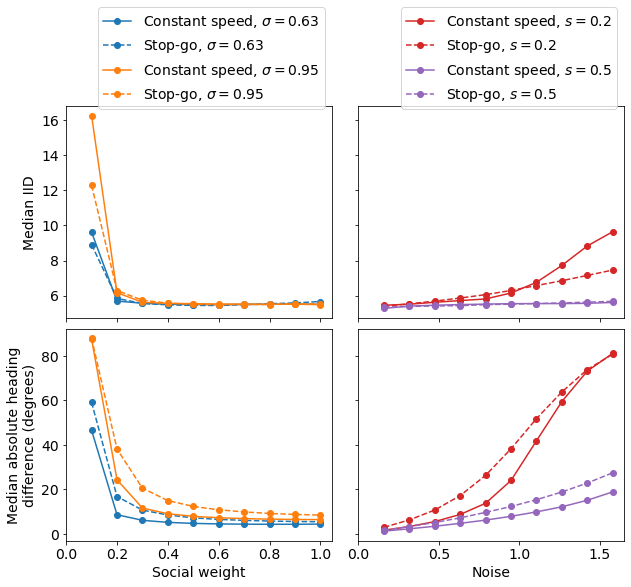

In [317]:
f,ax = plt.subplots(2,2,sharex='col',sharey='row')
f.set_size_inches(10,8)


simprefix='pairsameABC'
outfile = 'simresults/'+simprefix+'.pkl'
[frontback,leftright,dtheta,distapart,speed,angvel] = pickle.load(open(outfile,'rb'))

#(A) 
speedvalues = [ [0.8, 0.8], [1, 1], [1.2, 1.2], [1.1, 0.9], [1.2, 0.8] ]
#(B)
socialweights = [0, 0.25, 0.5, 0.75, 1]
socialweights = np.arange(0,1.01,0.1)
#(C) 
sigma_turns = [2,3]


statnum = 2  # 0=mean, 1=stddev, 2=median
for C in range(2):
    for snum in range(2):
        Clabel = ', ' + '$\sigma=$' + str(round(sigma_turns[C]*np.sqrt(0.1),2))
        label=['Constant speed','Stop-go'][snum] + Clabel
        style = '-o' if snum==0 else '--o'
        #  Distance apart
        a=ax[0,0]
        a.plot(socialweights[1:],distapart[snum,C,:][1:,statnum],style,label=label,c=snscolors[C])

        # Alignment
        a=ax[1,0]
        a.plot(socialweights[1:],dtheta[snum,C,:][1:,statnum]*180/np.pi,style,label=label,c=snscolors[C])

simprefix='pairsameDEF'
outfile = 'simresults/'+simprefix+'.pkl'
[frontback,leftright,dtheta,distapart,speed,angvel] = pickle.load(open(outfile,'rb'))

#(B)
socialweights = [0.2, 0.5]
#(C) 
sigma_turns = np.arange(0.5,5.01,0.5)


statnum = 2  # 0=mean, 1=stddev, 2=median

for B in range(2):
    for snum in range(2):
        Clabel = ', ' + '$s=$' + str(round(socialweights[B],2))
        label=['Constant speed','Stop-go'][snum] + Clabel
        style = '-o' if snum==0 else '--o'
        #  Distance apart
        a=ax[0,1]
        a.plot(sigma_turns[:]*np.sqrt(0.1),distapart[snum,B,:][:,statnum],style,label=label,c=snscolors[B+3])

        # Alignment
        a=ax[1,1]
        a.plot(sigma_turns[:]*np.sqrt(0.1),dtheta[snum,B,:][:,statnum]*180/np.pi,style,label=label,c=snscolors[B+3])

        
ax[1,0].set_xlabel('Social weight',fontsize=14)  
ax[1,1].set_xlabel('Noise',fontsize=14)

ax[0,0].legend(bbox_to_anchor=(1, 1.5),fontsize=14)    
ax[0,1].legend(bbox_to_anchor=(1, 1.5),fontsize=14)    
plt.subplots_adjust(wspace=0.1,hspace=0.05)
ax[0,0].set_ylabel('Median IID',fontsize=14)
ax[1,0].set_ylabel('Median absolute heading\ndifference (degrees)',fontsize=14)
[[a.tick_params(labelsize=14) for a in aa] for aa in ax]

[a.set_xlim((0,None)) for a in ax[0]]

plt.savefig('PairSame.pdf')
plt.show()

# Pairdiff 

In [320]:
simprefix = 'pairdiff'

#(A) 
dsvalues = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
speedvalues = np.array([np.ones(2) + np.array([ds/2,-ds/2]) for ds in dsvalues])
#(B)
dsocialvalues = [1, 0.6, 0.3 ,0,-0.3, -0.6, -1]
meansocial = 0.5
socialweights = np.array([meansocial*np.ones(2) + np.array([ds/2,-ds/2]) for ds in dsocialvalues])
#(C) 
C=0  # not used here
#(D) 
speedsocialweights = [0,0.1]

# stopgo:  on/off
#(m) 
stopgosocials = [0,0.4,0.8]
#(n) Tswitch:  Fish 1 always [10,10].  Fish 2:  [10,10], [30,10]  "Time in each state [go,stop]"  (2 cases)
Tswitchs = [[10,10], [30,10]]  # Tswitch values for Fish 2


# parameters that I'm not varying this time
tau_speed = 1
statespeedmult = np.array([[1. , 0.2],[1. , 0.2]])
sigma_turn = 3

# simulation configuration and other set parameters
numparticles=2
numsteps = 20 * 10**6  # should really use 2 * 10**6
dt = 0.1
# numsteps=100



# set outside the loop
D=0

m = 2 # use higher value of stop-go social
# n = 0 # Tswitch

C = 0 # sigma_turn.  
D = 0 # speedsocialweight
statnum = 2  #0=mean, 1=stddev, 2=median


process_raw_results = False
if process_raw_results:
    lengths = [2,len(Tswitchs),len(speedvalues),len(socialweights)]
    frontback = np.zeros(np.append(lengths,3))
    leftright = np.zeros(np.append(lengths,3))
    dtheta = np.zeros(np.append(lengths,3))
    distapart = np.zeros(np.append(lengths,3))
    speed = np.zeros(np.concatenate((lengths,[2,3])))
    angvel = np.zeros(np.concatenate((lengths,[2,3])))
    
    for snum in range(2):    
        for n in range(2 if snum==1 else 1):
            for A in range(len(speedvalues)):
                print(A)
                for B in range(len(socialweights)):
                    if snum==1:  # then stopgosim=True
                        savename = simprefix+'_'+str(m)+str(n)+'_params_'+str(A)+str(B)+str(C)+str(D)+'.pklz'
                    else:
                        savename = simprefix+'_params_'+str(A)+str(B)+str(C)+str(D)+'.pklz'   
                    if os.path.exists(savedir+savename):
                        [model,allparticles,alldist,alldcoords_rotated] = pickle.load( gzip.open(savedir+savename,'rb') )
                        fb, lr, dth, dist, fb_val, lr_val, dth_val, dist_val, s, s_val, av, av_val = getsimmetrics(savename,dskip=10,social_dsel=False)  # if social_dsel=False, then name it '-alld'            
                        frontback[snum,n,A,B] = fb
                        leftright[snum,n,A,B] = lr
                        dtheta   [snum,n,A,B] = dth
                        distapart[snum,n,A,B] = dist
                        speed [snum,n,A,B] = s
                        angvel[snum,n,A,B] = av    
    outfile = 'simresults/'+simprefix+'.pkl'
    pickle.dump([frontback,leftright,dtheta,distapart,speed,angvel],open(outfile,'wb'))
    print('wrote to:',outfile)      
else:
    outfile = 'simresults/'+simprefix+'.pkl'
    [frontback,leftright,dtheta,distapart,speed,angvel] = pickle.load(open(outfile,'rb'))  

## A,B:  Constant speed model

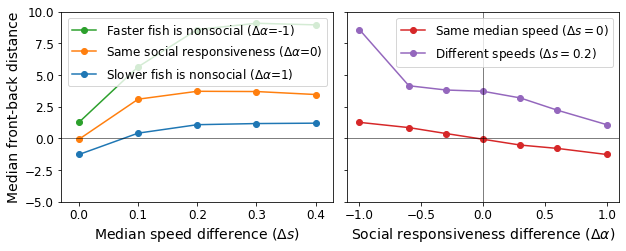

In [322]:
snum= 0 # just get constant speed model
n = 0 # Tswitch

# A = # speedvalues
Bsel = [0,3,6]
Asel = [0,2]  # dspeed values
statnum=2

numtoplot=5


f, ax = plt.subplots(1,2,sharey=True)
f.set_size_inches(10,3.5)

a=ax[0]
medianfrontback = frontback[snum,n,:,Bsel,statnum]
dspeed_actual = speed[snum,n,:,Bsel,0,statnum] - speed[snum,n,:,Bsel,1,statnum]
labels = ['Slower fish is nonsocial ($\Delta \\alpha$=1)','Same social responsiveness ($\Delta \\alpha$=0)','Faster fish is nonsocial ($\Delta \\alpha$=-1)']
for i in [2,1,0]:
    a.plot(dsvalues[:numtoplot],medianfrontback[i][:numtoplot],'-o',label=labels[i],c=snscolors[i])
    

a=ax[1]
medianfrontback = frontback[snum,n,Asel,:,statnum]
dspeed_actual = speed[snum,n,Asel,:,0,statnum] - speed[snum,n,Asel,:,1,statnum]
labels=['Same median speed ($\Delta s=0$)','Different speeds ($\Delta s='+str(dsvalues[Asel[1]])+'$)']
for i in range(2):
    a.plot(dsocialvalues,medianfrontback[i],'-o',label=labels[i],c=snscolors[i+3])
    
a=ax[0]
a.set_xlabel('Median speed difference ($\Delta s$)',fontsize=14)
a.axhline(0,c='k',linewidth=0.5)
a.set_ylabel('Median front-back distance',fontsize=14)
a.set_ylim([-5,10])
a.set_xlim([-0.03,0.43])

a=ax[1]
a.axhline(0,c='k',linewidth=0.5)
a.axvline(0,c='k',linewidth=0.5)
a.set_xlabel('Social responsiveness difference ($\Delta \\alpha$)',fontsize=14)

[a.legend(fontsize=12) for a in ax]
[a.tick_params(labelsize=12) for a in ax]

plt.subplots_adjust(wspace=0.05)
plt.savefig('leadership-constspeed.pdf')

### C:  stop=go model

In [246]:
# interpolation function
snum=1
dspeed_actual_all = speed[snum,:,:,:,0,statnum] - speed[snum,:,:,:,1,statnum]
xx,yy = np.meshgrid(dsvalues, dsocialvalues)
intsg_same = scipy.interpolate.interp2d(xx, yy, dspeed_actual_all[0].T)
intsg_longer = scipy.interpolate.interp2d(xx, yy, dspeed_actual_all[1].T)

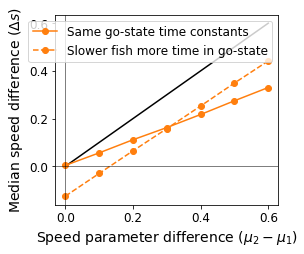

In [315]:
# plot actual speed vs set parameter speed
f, ax = plt.subplots(1,1)
f.set_size_inches(4,3.5)
a=ax

xtp = dsvalues
a.plot([0.0,0.6],[0.0,0.6],'k')
a.plot(xtp,intsg_same(xtp,0),'-o',c=snscolors[1],label='Same go-state time constants')
a.plot(xtp,intsg_longer(xtp,0),'--o',c=snscolors[1],label='Slower fish more time in go-state')

a.legend(fontsize=12)
a.tick_params(labelsize=12)
a.axhline(0,c='k',linewidth=0.5)
a.axvline(0,c='k',linewidth=0.5)
a.set_ylabel('Median speed difference ($\Delta s$)',fontsize=14)
a.set_xlabel('Speed parameter difference ($\mu_2-\mu_1$)',fontsize=14)
plt.savefig('stopgo-speedplot.pdf')

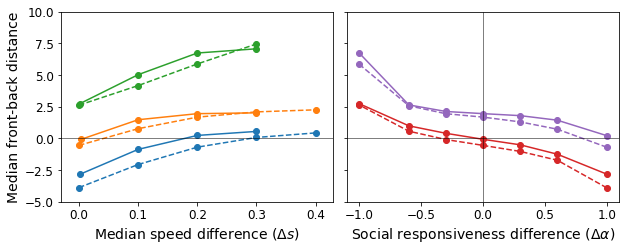

In [316]:
snum= 1 # just get stop-gomodel

# A = # speedvalues
Bsel = [0,3,6]
statnum = 2  #0=mean, 1=stddev, 2=median

snum= 1 # just get constant speed model

Asel = [0,2]  # dspeed values
# B=3  # same social weight is B=3
statnum = 2  #0=mean, 1=stddev, 2=median


f, ax = plt.subplots(1,2,sharey=True)
f.set_size_inches(10,3.5)

a=ax[0]
medianfrontback = frontback[snum,:,:,Bsel,statnum]
dspeed_actual = speed[snum,:,:,Bsel,0,statnum] - speed[snum,:,:,Bsel,1,statnum]
labels = ['Slower fish is nonsocial ($\Delta \\alpha$=1)','Same social responsiveness ($\Delta \\alpha$=0)','Faster fish is nonsocial ($\Delta \\alpha$=-1)']
for n in range(2):
    style = '-o' if n==0 else '--o'
    Tswitchlabel = ['Same time in stop-go states','Slower fish longer in go state'][n]
    for i in range(3):
        x=dspeed_actual[i,n]
        ifn = scipy.interpolate.interp1d(x,medianfrontback[i,n])
        xtp = np.array(dsvalues)[(np.array(dsvalues)<np.max(x)) & (np.array(dsvalues)>np.min(x))]
        if xtp[0]>0:
            xtp = np.concatenate(([x[0]],xtp))
#         a.plot(dspeed_actual[i,n],medianfrontback[i,n],style,label=labels[i],c=snscolors[i])
        a.plot(xtp,ifn(xtp),style,label=labels[i],c=snscolors[i])        
    

    
a=ax[1]
dspd_desireds = np.array(dsvalues)[Asel]  # dspeed values

for n in range(2):
    fn = intsg_same if n==0 else intsg_longer
    style = '-o' if n==0 else '--o'
    Tswitchlabel = ['Same time in stop-go states','Slower fish longer in go state'][n]
    for i in range(2):
        dspd_desired = dspd_desireds[i]
        # solve for values to plot
        tp = np.zeros(len(dsocialvalues))
        for B in range(len(dsocialvalues)):
            dsocial = dsocialvalues[B]

            # first, solve for the speed parameter value that gives the desired difference in actual speed
            if (dspd_desired==0) & (fn(0,dsocial)>0):
                val = 0
            else:
                f = lambda x: fn(x,dsocial)-dspd_desired
                sol = scipy.optimize.root_scalar(f, bracket=[0, 0.6], method='brentq')
                val = sol.root
        #         print(val)

            # then, interpolate median front back for this spee
            medianfrontback = frontback[snum,n,:,B,statnum]
            fbint = scipy.interpolate.interp1d(dsvalues,medianfrontback)
            tp[B] = fbint(val)        
        # plot them            
        a.plot(dsocialvalues,tp,style,label=Tswitchlabel+', deltaspeedparam='+str(dsvalues[Asel[i]]),c=snscolors[i+3])
    
 
    
    
a=ax[0]
a.set_xlabel('Median speed difference ($\Delta s$)',fontsize=14)
a.axhline(0,c='k',linewidth=0.5)
a.set_ylabel('Median front-back distance',fontsize=14)
a.set_ylim([-5,10])
a.set_xlim([-0.03,0.43])

a=ax[1]
a.axhline(0,c='k',linewidth=0.5)
a.axvline(0,c='k',linewidth=0.5)
a.set_xlabel('Social responsiveness difference ($\Delta \\alpha$)',fontsize=14)

# [a.legend(fontsize=12) for a in ax]
[a.tick_params(labelsize=12) for a in ax]

plt.subplots_adjust(wspace=0.05)
plt.savefig('leadership-stopgo.pdf')